In [1]:
import numpy as np
from matplotlib import rcParams, pyplot as plt 
from math import sqrt
from scipy.stats import norm, invgamma, gaussian_kde, multivariate_normal
%matplotlib inline
rcParams['figure.figsize'] = (10,10)

# Gibbs Sampling

# Problem 1

In [10]:
# Problem 1 - Gibbs sampler function 
def gibbs(y, mu0, sigma02, alpha, beta, n_samples):
    samples = []
    n = len(y)
    s = np.sum(y)
    mu = mu0
    sigma2 = sigma02
    star_alpha = alpha + 0.5 * n
    for _ in xrange(n_samples):
        # Get intermediate quantities
        star_sigma2 = 1./float(1./sigma02 + float(n)/sigma2)
        star_mu = star_sigma2 * (mu0/sigma02 + (1./sigma2)*s)
        star_beta = beta + 0.5*np.sum((y - mu)**2.)
        
        # Update mu and sigma2
        mu = norm.rvs(star_mu, scale=sqrt(star_sigma2))
        sigma2 = invgamma.rvs(star_alpha, scale=star_beta)
        
        # Append mu and sigma2 to samples
        samples.append([mu, sigma2])
    return np.array(samples)

In [11]:
scores = np.genfromtxt('examscores.csv', delimiter=",")
#scores = np.random.randint(1,20,500).astype(float) + 75.
samples = gibbs(scores, 80., 16., 3., 50., 1000)
mu_samples, sigma2_samples = samples[:,0], samples[:,1]

# Plot the convergence of mu and sigma2
plt.subplot(2,1,1)
plt.plot(np.arange(1, 1001, step=1), mu_samples)
plt.title('Convergence of $\mu$')
plt.subplot(2,1,2)
plt.plot(np.arange(1, 1001, step=1), sigma2_samples)
plt.title('Convergence of $\sigma^2$')
plt.show()

# Problem 2


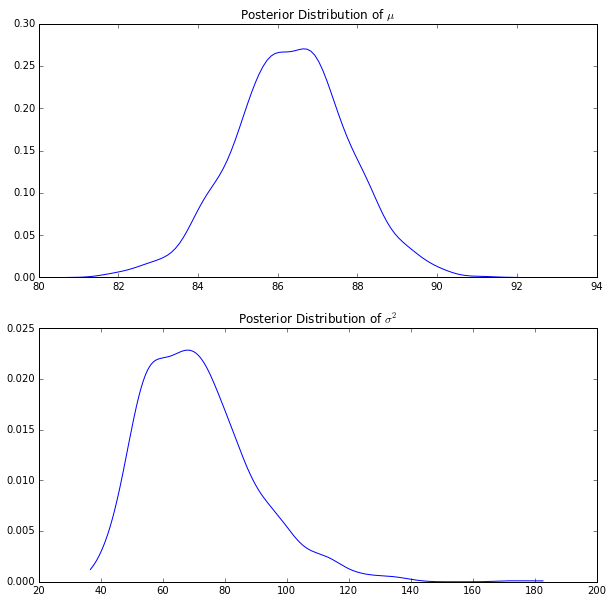

In [12]:
# Create the mu kernel density estimator, plot
mu_kernel = gaussian_kde(mu_samples)
x_min = min(mu_samples) -1
x_max = max(mu_samples) + 1
x = np.arange(x_min, x_max, step=0.1)
plt.subplot(2,1,1)
plt.plot(x, mu_kernel(x))
plt.title('Posterior Distribution of $\mu$')

# Creat ethe sigma^2 kernel density estimator, plot
sigma_kernel = gaussian_kde(sigma2_samples)
x_min = min(sigma2_samples) - 1
x_max = max(sigma2_samples) + 1
x = np.arange(x_min, x_max, step=0.1)
plt.subplot(2,1,2)
plt.plot(x, sigma_kernel(x))
plt.title('Posterior Distribution of $\sigma^2$')
plt.show()

# Problem 3

In [13]:
# Sample from each of the mu, sigma2 pairs to get our predictive posterior distribution
predictive_samples = []
for i in xrange(len(mu_samples)):
    predictive_samples.append(norm.rvs(mu_samples[i], scale=sqrt(sigma2_samples[i])))

# Plot the predictive samples via kernal density estimators
scores_kernel = gaussian_kde(np.array(predictive_samples))
x_min = min(predictive_samples) - 1
x_max = max(predictive_samples) + 1
x = np.arange(x_min, x_max, step=0.1)
plt.plot(x, scores_kernel(x))
plt.title('Predictive Posterior Distribution of Exam Scores')
plt.show()

# LDA 

# Problems 4-7

In [29]:
from scipy.special import gammaln
import string

def loadStopwords(filename):
    """ This function is given. """
    infile = open(filename,'r')
    stopwords = infile.readlines()
    for i in xrange(len(stopwords)):
        stopwords[i] = stopwords[i].rstrip()
    stopwords.append('')
    return stopwords

class LDACGS(object):

    def __init__(self, n_topics, alpha = 0.1, beta = 0.1):
        """ This function is given. """
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def buildCorpus(self,filename,stopwords=None):
        """ This function is given. """
        infile = open(filename,'r')
        doclines = [line.rstrip().translate(string.maketrans("",""),string.punctuation).lower().split(' ') for line in infile]
        n_docs = len(doclines)
        self.vocab = []
        for i in xrange(n_docs):
            self.vocab += doclines[i]
        self.vocab = list(set(self.vocab))
        if stopwords != None:
            self.vocab = np.sort(self._removeStopwords(stopwords)).tolist()
        self.documents = []
        for i in xrange(n_docs):
            self.documents.append({})
            for j in xrange(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])

    def initialize(self):
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)

        # initialize the three count matrices
        # the (i,j) entry of self.nmz is # of words in document i assigned to topic j
        self.nmz = np.zeros((self.n_docs,self.n_topics))
        # the (i,j) entry of self.nzw is # of times term j is assigned to topic i
        self.nzw = np.zeros((self.n_topics,self.n_words))
        # the (i)-th entry is the number of times topic i is assigned in the corpus
        self.nz = np.zeros(self.n_topics)

        # initialize the topic assignment dictionary
        self.topics = {} # key-value pairs of form (m,i):z
        for m in xrange(self.n_docs):
            for i in self.documents[m]:
                # Get random topic assignment, i.e. z = ...
                # Increment count matrices
                # Store topic assignment, i.e. self.topics[(m,i)]=z
                z = np.random.randint(0,self.n_topics)
                ind = self.documents[m][i]
                self.nmz[m,z] += 1.
                self.nzw[z,ind] += 1.
                self.nz[z] += 1.
                self.topics[(m,i)] = z

    def sample(self,filename, burnin=100, sample_rate=10, n_samples=10, stopwords=None):
        self.buildCorpus(filename,stopwords)
        self.initialize()
        self.total_nzw = np.zeros((self.n_topics,self.n_words))
        self.total_nmz = np.zeros((self.n_docs,self.n_topics))
        self.logprobs = np.zeros(burnin + sample_rate*n_samples)
        for i in xrange(burnin):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[i] = self._loglikelihood()
        for i in xrange(n_samples*sample_rate):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[burnin+ i] = self._loglikelihood()
            if not i%sample_rate:
                # accumulate counts
                self.total_nzw += self.nzw
                self.total_nmz += self.nmz
        self.phi()
        self.theta()

    def phi(self):
        """ This function is given. """
        phi = self.total_nzw + self.beta
        self._phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def theta(self):
        """ This function is given. """
        theta = self.total_nmz + self.alpha
        self._theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self,n_terms=10):
        """ This function is given. """
        vec = np.atleast_2d(np.arange(0,self.n_words))
        topics = []
        for k in xrange(self.n_topics):
            probs = np.atleast_2d(self._phi[k,:])
            mat = np.append(probs,vec,0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1,self.n_words - 1 - i])] for i in xrange(n_terms)])
        return topics

    def toplines(self,n_lines=5):
        """ This function is given. """
        lines = np.zeros((self.n_topics,n_lines))
        for i in xrange(self.n_topics):
            args = np.argsort(self._theta[:,i]).tolist()
            args.reverse()
            lines[i,:] = np.array(args)[0:n_lines] + 1
        return lines

    def _removeStopwords(self,stopwords):
        """ This function is given. """
        output = []
        for x in self.vocab:
            if x not in stopwords:
                output.append(x)
        return output

    def _conditional(self, m, w):
        """
        This function is given. Compute the conditional distribution of
        the topic corresponding to document m and word index w.
        Returns a distribution vector of length self.n_topics.
        """
        dist = (self.nmz[m,:] + self.alpha) * (self.nzw[:,w] + self.beta) / (self.nz + self.beta*self.n_words)
        #for i in xrange(len(dist)):
        #    if dist[i] < 0.:
        #        dist[i] = 0.
        return dist/sum(dist)

    def _sweep(self):
        for m in xrange(self.n_docs):
            for i in self.documents[m]:
                # Retrieve vocab index for i^th word in document m
                # Retrieve topic assignment for i^th word in document m
                
                ind = self.documents[m][i]
                topic = self.topics[(m,i)]
                
                # Get conditional distribution
                # Sample new topic assignment
                dist = self._conditional(m, ind)
                #z = np.argmax(np.random.multinomial(1, dist))
                z = np.random.choice(range(len(dist)), p=dist)
                
                # Decrement count matrices
                # Increment count matrices
                # Store new topic assignment
                self.nmz[m,topic] -= 1.
                self.nzw[topic,ind] -= 1.
                self.nz[topic] -= 1.
                self.nmz[m,z] += 1.
                self.nzw[z,ind] += 1.
                self.nz[z] += 1.
                self.topics[(m,i)] = z
                

    def _loglikelihood(self):
        """ This function is given. """
        lik = 0

        for z in xrange(self.n_topics):
            lik += np.sum(gammaln(self.nzw[z,:] + self.beta)) - gammaln(np.sum(self.nzw[z,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words*self.beta)

        for m in xrange(self.n_docs):
            lik += np.sum(gammaln(self.nmz[m,:] + self.alpha)) - gammaln(np.sum(self.nmz[m,:] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics*self.alpha)

        return lik


In [8]:
stop_words = loadStopwords('stopwords.txt')

In [30]:
LDA_model = LDACGS(20)

In [31]:
LDA_model.sample("reagan.txt", stopwords=stop_words)

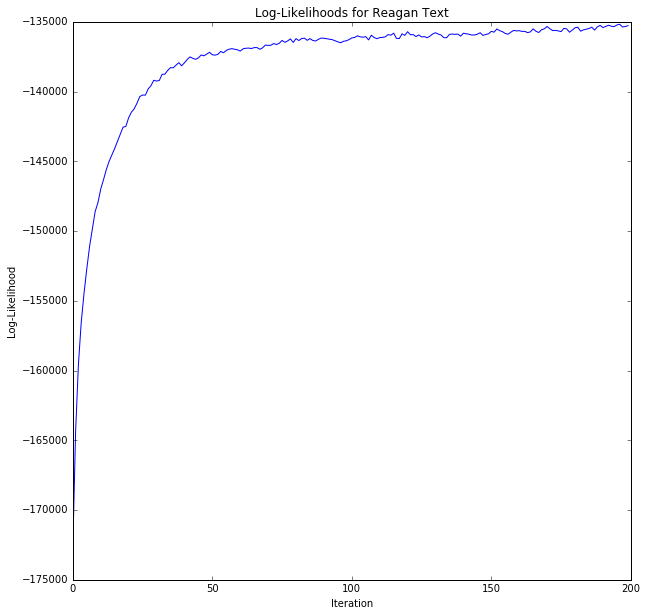

In [32]:
probs = LDA_model.logprobs
l = len(probs)
plt.plot(np.arange(0,l), probs)
plt.title('Log-Likelihoods for Reagan Text')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.show()

# Problem 8

In [33]:
n = 10
topic_topterms = LDA_model.topterms(n)

In [34]:
TOPICS = []
for l in topic_topterms:
    print l
    t = raw_input()
    print 'Is that the right topic you want to place?'
    ans = raw_input()
    while ans != 'y':
        print 'What topic would you like? '
        t = raw_input()
        print 'Is that correct?'
        ans = raw_input()
    TOPICS.append(t)

['mr', 'congress', 'speaker', 'tonight', 'members', 'president', 'americans', 'house', 'citizens', 'fellow']
congress
Is that the right topic you want to place?
y
['freedom', 'tax', 'nicaragua', 'support', 'people', 'democracy', 'reform', 'democratic', 'america', 'central']
democracy
Is that the right topic you want to place?
y
['jobs', 'tax', 'program', 'people', 'economic', 'work', 'job', 'recovery', 'economy', 'american']
economy
Is that the right topic you want to place?
y
['freedom', 'world', 'peace', 'america', 'free', 'economic', 'tonight', 'future', 'year', 'economy']
freedom
Is that the right topic you want to place?
y
['god', 'bless', 'congress', 'american', 'administration', 'force', 'president', 'effective', 'friends', 'interests']
geopolitical relationships
Is that the right topic you want to place?
y
['states', 'federal', 'programs', 'local', 'time', 'government', 'years', 'state', 'governments', 'people']
state government
Is that the right topic you want to place?
y
['bu

In [35]:
print 'The topics present are:'
for t in TOPICS:
    print t

The topics present are:
congress
democracy
economy
freedom
geopolitical relationships
state government
legislative process
child family education
budget
general government
interest and inflation
vision
taxes
federal spending
'murica
social programs
free people
international trade
cold war
american history


# Metropolis Algorithm

# Example from Lab

In [17]:
scores = np.loadtxt('examscores.csv')
alpha = 3
beta = 50
mu0 = 80
sig20 = 16

muprior = norm(loc=mu0, scale=sqrt(sig20))
sig2prior = invgamma(alpha, scale=beta)

def proposal(y, s):
    return multivariate_normal.rvs(mean=y, cov=s*np.eye(len(y)))

def propLogDensity(x):
    return muprior.logpdf(x[0]) + sig2prior.logpdf(x[1]) + norm.logpdf(scores, loc=x[0],scale=sqrt(x[1])).sum()

In [18]:
def metropolis(x0, s, n_samples):
    """
    Use the Metropolis algorithm to sample from posterior.
    
    Parameters
    ----------
    x0 : ndarray of shape(2,)
        The first entry is mu, the second entry is sigma2
    s : float > 0
        The standard deviation parameter for the proposal function
    n_samples : int
        The number of samples to generate
        
    Returns
    -------
    draws : ndarray of shape (n_samples, 2)
        The MCMC samples
    logprobs : ndarray of shape (n_samples)
        The log density of the samples
    accept_rate : float
        The porportion of proposed samples that were accepted
    """
    accept_counter = 0
    total = 0
    draws = np.empty((n_samples, 2))
    logprob = np.empty(n_samples)
    x = x0.copy()
    while accept_counter < n_samples:
        total += 1
        xprime = proposal(x, s)
        u = np.random.rand(1)[0] + 1e-10
        if np.log(u) <= propLogDensity(xprime) - propLogDensity(x):
            x = xprime
            draws[accept_counter] = x
            logprob[accept_counter] = propLogDensity(x)
            accept_counter += 1
    return draws, logprob, accept_counter/float(total)
    
    

In [20]:
draws, lprobs, rate = metropolis(np.array([80.,10.]), 20., 10000)
print "Acceptance Rate: " + str(rate)

Acceptance Rate: 0.35365681143


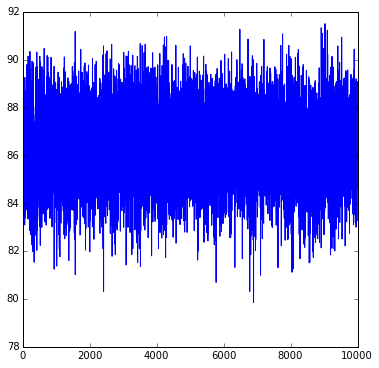

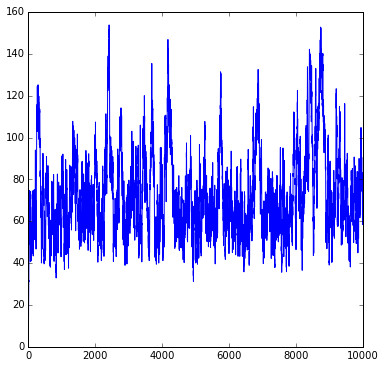

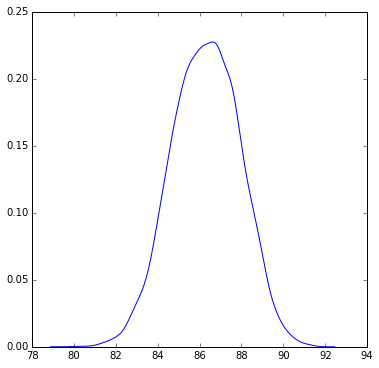

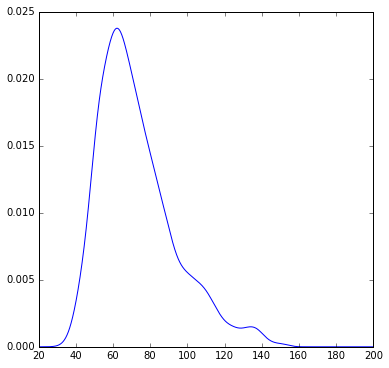

In [23]:
rcParams['figure.figsize'] = (6,6)
# plot the first 500 log probs
plt.plot(lprobs[:500])
plt.show()
# plot the mu samples
plt.plot(draws[:,0])
plt.show()
# plot the sigma2 samples
plt.plot(draws[:,1])
plt.show()
# build and plot KDE for posterior mu
mu_kernel = gaussian_kde(draws[50:,0])
x_min = min(draws[50:,0]) - 1
x_max = max(draws[50:,0]) + 1
x = np.arange(x_min, x_max, step=0.1)
plt.plot(x,mu_kernel(x))
plt.show()
# build and plot KDE for posterior sigma2
sig_kernel = gaussian_kde(draws[50:,1])
x_min = 20
x_max = 200
x = np.arange(x_min, x_max, step=0.1)
plt.plot(x,sig_kernel(x))
plt.show()

# Problem 1


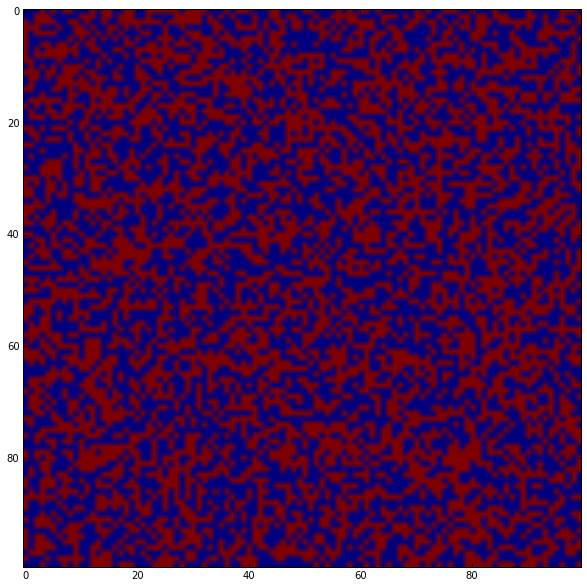

In [35]:
def initialize_spin(n):
    return 2*np.random.randint(0,2,n**2).reshape(n,n) - 1

rcParams['figure.figsize'] = (10,10)
lattice = initialize_spin(100)
plt.imshow(lattice)
plt.show()

# Problem 2

In [25]:
def energy_with_adj(A, i, j, n):
    tot = 0
    spin_center = A[i,j]
    for neighbor in [((i+1)%n,j), ((i-1)%n, j), (i,(j+1)%n), (i, (j-1)%n)]:
        tot -= spin_center * A[neighbor[0], neighbor[1]]
    return tot

def calc_energy(A):
    n = A.shape[0]
    H = 0      
    for x in xrange(n**2):
        i_x = x / n
        j_x = x % n
        H += energy_with_adj(A, i_x, j_x, n)
    return H 

orig_energy = calc_energy(lattice)
print "The energy in the lattice is " + str(orig_energy)

The energy in the lattice is 232


# Problem 3

In [26]:
def new_spin(A):
    n = A.shape[0]
    x = np.random.randint(0,n**2)
    return x / n, x % n

In [27]:
# example of returning a pair of indices chosen at random from our function
print "A pair of indices to flip the spin is: " + str(new_spin(lattice))

A pair of indices to flip the spin is: (77, 14)


# Problem 4

In [28]:
def calc_energy_flip(A, H, index):
    n = A.shape[0]
    i, j = index
    # flip spin of the specified element
    A[i,j] = -A[i,j]
    return H + 2 * energy_with_adj(A,i,j,n)

new_energy = calc_energy_flip(lattice, orig_energy, new_spin(lattice))
print "The original energy was: " + str(orig_energy)
print "The new energy, with flipped spin is: " + str(new_energy)


The original energy was: 232
The new energy, with flipped spin is: 232


# Problem 5

In [29]:
def accept_proposed(H_curr, H_prop, beta):
    if H_prop <= H_curr:
        return True
    else:
        if np.random.rand() <= np.exp(beta*(H_curr - H_prop)):
            return True
        return False
    

# Problem 6

In [30]:
def prob6(n=100, beta=0.2, iterations=200000, n_samples=5000, sample_rate=100):
    """
    Inputs:
    --------
    n : int
        dimension of the lattice
    beta : float
        temperature constant
    iterations : int
        number of iterations to do
    n_samples : int
        number of samples to compute
    sample_rate : int
        rate at which to record the samples generated
    
    Outputs:
    --------
    samples : list 
        of the lattices at every sample_rate^th sample
    
    probs : numpy array 
        probabilities (-beta*H_current), where H_current is the energy of the current lattice
    
    
    """
    # initialize our lattice spin configuration and acceptance counter
    lattice = initialize_spin(n)
    H_c = calc_energy(lattice)
    accept_counter = 0
    samples = []
    probs = []
    
    burnin = iterations - n_samples
    
    for _ in xrange(iterations):
        # Calculater the energy of the proposed flip
        i, j = new_spin(lattice)
        H_p = calc_energy_flip(lattice, H_c, (i,j))
        
        # If the new flip configuration is accepted, then we...
        if accept_proposed(H_c, H_p, beta):
            # update the lattice and current energy
            lattice[i,j] = -lattice[i,j]
            H_c = H_p
            probs.append(-beta * H_c)

            if accept_counter >= burnin and (accept_counter - burnin) % sample_rate == 0:
                    samples.append(lattice)
                
        accept_counter += 1
                
    
    return samples, np.array(probs) 
            
  

# Problem 7

We run our Metropolis sampling with 2 different values of beta (1.0, 0.2), on a $100 \times 100$ lattice with 200000 iterations, with 5000 samples so that we keep 50 sample lattices.

In [37]:
# Run Metropolis Sampling with beta = 1.0
lattices, probs = prob6(beta=1.0)

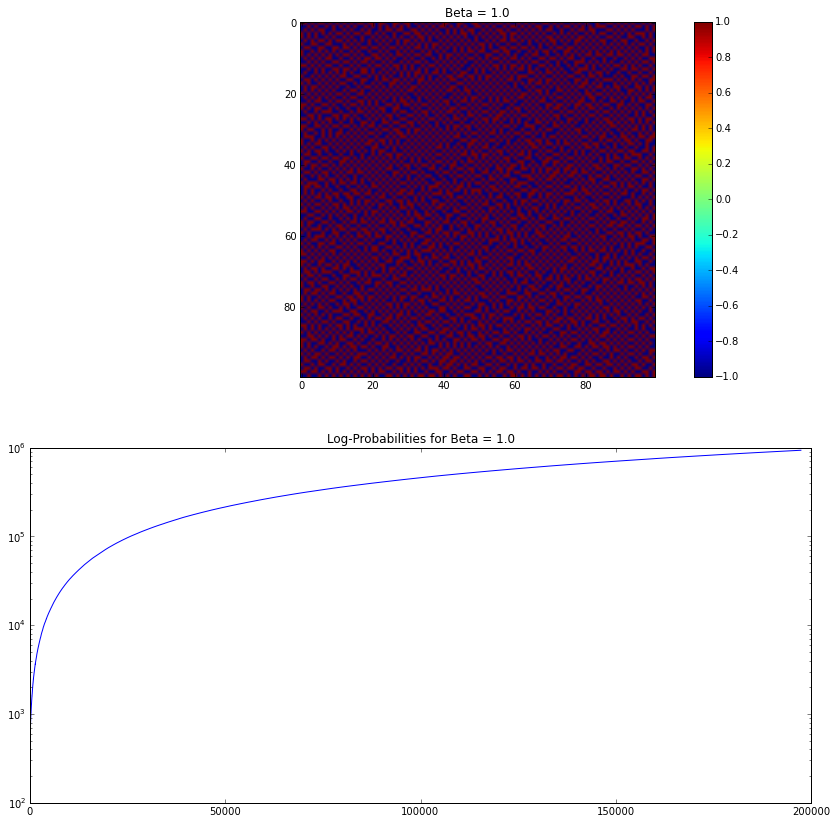

In [38]:
late_lattice = lattices[-3]
rcParams['figure.figsize'] = (14,14)
plt.subplot(2,1,1)
plt.imshow(late_lattice)
plt.title('Beta = 1.0')
plt.colorbar()
plt.subplot(2,1,2)
plt.semilogy(np.arange(len(probs)), probs)
plt.title('Log-Probabilities for Beta = 1.0')
plt.show()

In [39]:
# Run Metropolis Sampling with beta = 0.2
lattices, probs = prob6(beta=0.2)

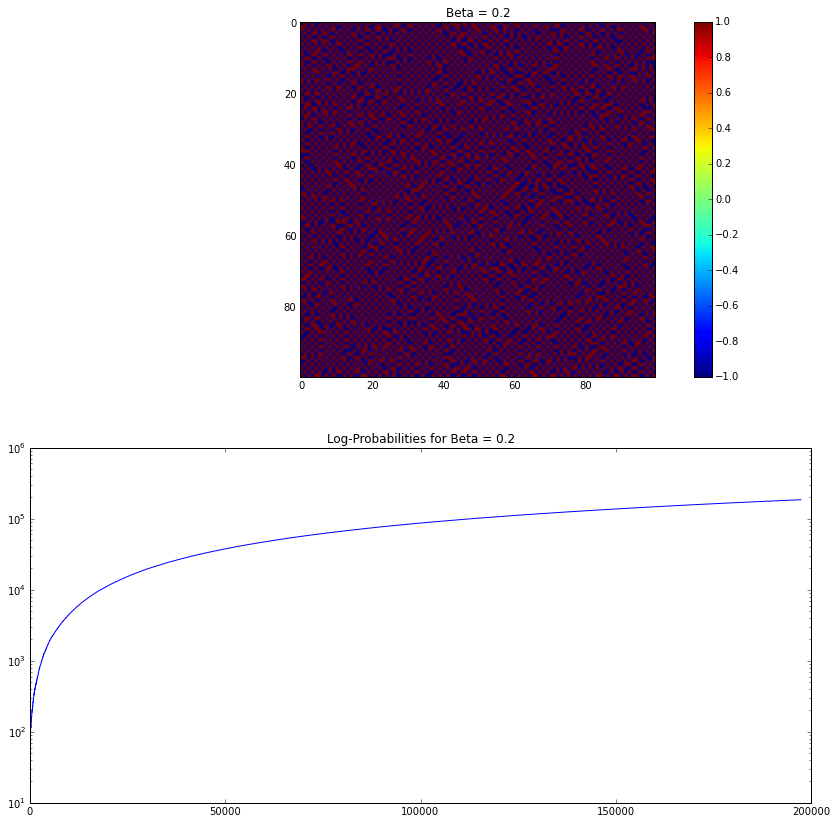

In [41]:
late_lattice = lattices[-3]
rcParams['figure.figsize'] = (14,14)
plt.subplot(2,1,1)
plt.imshow(late_lattice)
plt.title('Beta = 0.2')
plt.colorbar()
plt.subplot(2,1,2)
plt.semilogy(np.arange(len(probs)), probs)
plt.title('Log-Probabilities for Beta = 0.2')
plt.show()